### SVHN Preprocessing
This notebook implements SVHN pre-processing. The key steps are:

1. Read in some sample images and play with them.
2. Pull in full data (a) Extract labels and dimensions for each bounding box (height, width, left, top); (b) Resize and crop around the bounding box for each image; (c) Store in something more useful for python, such as a pickle file.

In [95]:
import scipy.ndimage as img
import scipy.misc as misc
import h5py
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import os
import sklearn.preprocessing as skproc
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale
import DigitStructFile
import cPickle as pkl
%matplotlib inline

In [96]:
train_struct_loc = '/Users/pjmartin/Documents/Udacity/MachineLearningProgram/Project5/udacity-mle-project5/data/train/digitStruct.mat'
test_struct_loc = '/Users/pjmartin/Documents/Udacity/MachineLearningProgram/Project5/udacity-mle-project5/data/test/digitStruct.mat'
train_loc_root = '/Users/pjmartin/Documents/Udacity/MachineLearningProgram/Project5/udacity-mle-project5/data/train/'
test_loc_root = '/Users/pjmartin/Documents/Udacity/MachineLearningProgram/Project5/udacity-mle-project5/data/test/'
img_loc1 = train_loc_root + '1.png'
img_loc1_test = test_loc_root + '1.png'
# read in as B/W
# img1 = img.imread(img_loc1)
img1 = img.imread(img_loc1,mode='L')
img1_test = img.imread(img_loc1_test,mode='L')

(350, 741)
109


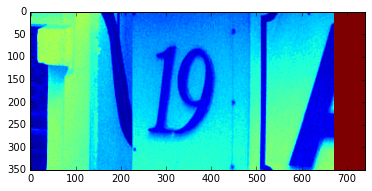

In [97]:
plt.imshow(img1)
print np.shape(img1)
print img1[0][0]

(47, 99)


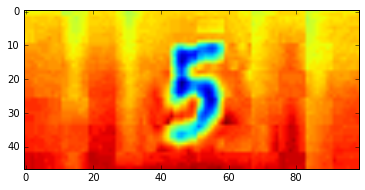

In [98]:
plt.imshow(img1_test)
print np.shape(img1_test)

In [100]:
train_digitstruct = DigitStructFile(train_struct_loc)
test_digitstruct = DigitStructFile(test_struct_loc)

In [101]:
train1_dict = train_digitstruct.getDigitStructure(0)
print train1_dict
test1_dict = test_digitstruct.getDigitStructure(0)
print test1_dict

{'name': '1.png', 'top': [77.0, 81.0], 'label': [1.0, 9.0], 'width': [81.0, 96.0], 'height': [219.0, 219.0], 'left': [246.0, 323.0]}
{'name': '1.png', 'top': [7.0], 'label': [5.0], 'width': [19.0], 'height': [30.0], 'left': [43.0]}


In [102]:
# Now, lets mess with the 1 image to crop to the bounding box.
def crop_dims(img_dict):
    mintop = int(np.min(img_dict['top']))
    top = int(mintop - np.ceil(0.1*mintop))
    minleft = int(np.min(img_dict['left']))
    left = int(minleft - np.ceil(0.1*minleft))
    total_height = int(np.max(img_dict['height']))
    height = int(total_height + np.ceil(0.05*total_height))
    total_width = int(np.sum(img_dict['width']))
    width = int(total_width + np.ceil(0.15*total_width))
    bottom = mintop + height
    right = minleft + width
    return [top, left, bottom, right]

In [103]:
# Tries to crop a square...
def square_dims(img_dict):
    mintop = np.min(img_dict['top'])
    minleft = np.min(img_dict['left'])
    height = np.max(img_dict['height'])
    width = np.sum(img_dict['width'])
    center_from_left = minleft + np.floor(width / 2.0)
    center_from_top = mintop + np.floor(height / 2.0)
    max_dim = max([height, width]) + 0.1*(max([height, width]))
    new_left = int(max([0, center_from_left - np.floor(max_dim/2.0)]))
    new_top = int(max([0, center_from_top - np.floor(max_dim/2.0)]))    
    return [new_top, new_left, int(new_top + max_dim), int(new_left + max_dim)]

In [104]:
train1_dims = crop_dims(train1_dict)
test1_dims = crop_dims(test1_dict)
print train1_dims
print test1_dims
train1_square_dims = square_dims(train1_dict)
test1_square_dims = square_dims(test1_dict)
print train1_square_dims
print test1_square_dims

[69, 221, 307, 450]
[6, 38, 39, 65]
[66, 214, 306, 454]
[6, 36, 39, 69]


In [105]:
# img1_crop = img1[min_top1:bottom1,min_left1:right1]
img1_crop = img1[train1_dims[0]:train1_dims[2],train1_dims[1]:train1_dims[3]]
img1_crop_square = img1[train1_square_dims[0]:train1_square_dims[2],train1_square_dims[1]:train1_square_dims[3]]
img1_test_crop = img1_test[test1_dims[0]:test1_dims[2],test1_dims[1]:test1_dims[3]]
img1_test_crop_square = img1_test[test1_square_dims[0]:test1_square_dims[2],test1_square_dims[1]:test1_square_dims[3]]

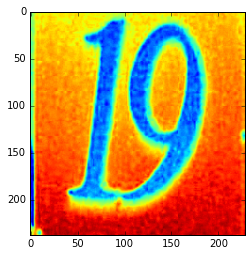

In [106]:
plt.imshow(img1_crop)

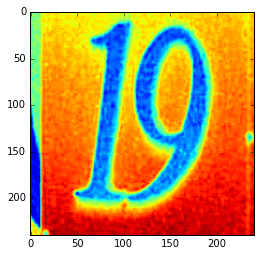

In [107]:
plt.imshow(img1_crop_square)

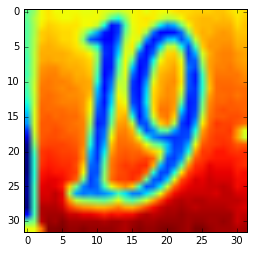

In [108]:
plt.imshow(misc.imresize(img1_crop_square, (32,32)))

In [54]:
# Crop to 32x32
# img1_rs = misc.imresize(img1_crop, (32,32))
# plt.imshow(img1_rs)

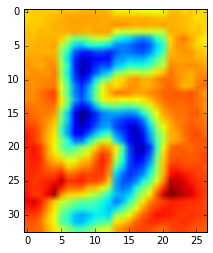

In [39]:
plt.imshow(img1_test_crop)

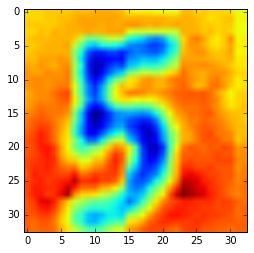

In [40]:
plt.imshow(img1_test_crop_square)

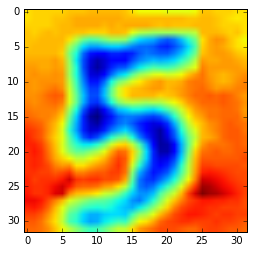

In [12]:
img1_test_rs = misc.imresize(img1_test_crop, (32,32))
plt.imshow(img1_test_rs)

The following code reads the images and crops according to the steps above. Then it encodes the label for each of these pieces of data. Most of this code migrated to the python script file.

In [13]:
# This function extracts and crops the indexed image.
def extract_and_crop(img_loc, img_dict, resize):
    curr_img = img.imread(img_loc + img_dict['name'],mode='L')
    img_shape = np.shape(curr_img)
    bb_top = np.min(img_dict['top'])
    bb_left = np.min(img_dict['left'])
    bb_height = np.max(img_dict['height'])
    bb_twidth = np.sum(img_dict['width'])
    # Add some pixel buffer before cropping.
    min_top = int( bb_top - 0.1*bb_top )
    min_left = int( bb_left - 0.1*bb_left )
    if min_left < 0:
        min_left = 0
    if min_top < 0:
        min_top = 0
    # ... a little less on the height
    total_height = int( bb_height + 0.05*bb_height )
    total_width = int( bb_twidth + 0.15*bb_twidth )

    curr_img_crop = curr_img[min_top:min_top+total_height,min_left:min_left+total_width]
    img_rs = misc.imresize(curr_img_crop, (resize,resize))
    return img_rs

In [14]:
# This function takes a digit struct and creates a one hot encoding of the data.
def extract_label(img_dict, encoder, max_len):
    # Build the label data with one hot encoding.
    street_label = np.array(img_dict['label']).astype(int)
    # Replace any instances of 10 with 0 - needed for one-hot encoding.
    street_label[street_label == 10] = 0
    curr_len = np.shape(street_label)[0]
    len_onehot = encoder.fit_transform(curr_len)
    y_onehot = np.concatenate((len_onehot, encoder.fit_transform(street_label.reshape(-1,1))),axis=0)
    # Create the padding for MAX_LENGTH - curr_len
    if max_len - curr_len > 0:
        nodigit_padding = np.array([10 for i in range(max_len-curr_len)])
        padding_onehot = encoder.fit_transform(nodigit_padding.reshape(-1,1))
        y_onehot = np.concatenate((y_onehot, padding_onehot), axis=0)
    return y_onehot

In [15]:
def generate_svhn_dataset(file_loc, n_vals, n_labels, crop_size, max_len):
    # Load from the digitstruct mat file.
    fname = os.path.join(file_loc, "digitStruct.mat")
    digitstruct = DigitStructFile(fname)
    data_len = len(digitstruct.digitStructName)
    X = np.zeros((data_len, crop_size, crop_size))
    y = np.zeros((data_len, n_labels, n_vals))

    invalid_idxs = []
    # Encoder for label generation.
    enc = skproc.OneHotEncoder(n_values=n_vals,sparse=False)
    for i in range(data_len):
        curr_dict = digitstruct.getDigitStructure(i)
        street_num_len = len(np.array(curr_dict['label']))
        if i % 1000 == 0:
            print "Processed through imgae " + str(i)
        if street_num_len <= 5 and street_num_len > 0:
            # Extract the label
            curr_y = extract_label(curr_dict, enc, max_len)
            curr_X = extract_and_crop(file_loc, curr_dict, crop_size)
            y[i,:,:] = curr_y
            X[i,:,:] = curr_X
        else:
            invalid_idxs.append(i)
            print "Invalid number! Index = " + str(i)
    X = np.delete(X,invalid_idxs,axis=0)
    y = np.delete(y,invalid_idxs,axis=0)
    return { 'data' : X, 'labels' : y }

In [16]:
def pickle_svhn(name, dataset):
    fname = "svhn_" + name + ".pkl"
    svhn_pkl_file = open(fname, 'wb')
    pkl.dump(dataset, svhn_pkl_file, -1)
    svhn_pkl_file.close()
    
def load_svhn_pkl(fname):
    svhn_pkl_file = open(fname, 'rb')
    loaded_dataset = pkl.load(svhn_pkl_file)
    svhn_pkl_file.close()
    return loaded_dataset

Let's visualize the training and test data sets. I will pull out **four** random images from each and apply the cropping function.

In [39]:
ds_train_fname = os.path.join(train_loc_root, "digitStruct.mat")
train_digitstruct = DigitStructFile(ds_train_fname)
train_len = len(train_digitstruct.digitStructName)
n_samples = 4
train_image_idxs = rnd.sample(range(train_len), n_samples)
print "Indices: " + str(train_image_idxs)

X_train_sample = np.zeros((n_samples, 32, 32))
y_train_sample = np.zeros((n_samples, 6, 11))
label_enc = skproc.OneHotEncoder(n_values=11,sparse=False)
idx = 0
for i in train_image_idxs:
    
    train_dict = train_digitstruct.getDigitStructure(i)
    street_num_len = len(np.array(train_dict['label']))
    if street_num_len <= 5 and street_num_len > 0:
        curr_y = extract_label(train_dict, label_enc, 5)
        curr_X = extract_and_crop(train_loc_root, train_dict, 32)
        y_train_sample[idx,:,:] = curr_y
        X_train_sample[idx,:,:] = curr_X
        idx = idx + 1


Indices: [7178, 4821, 20249, 13299]


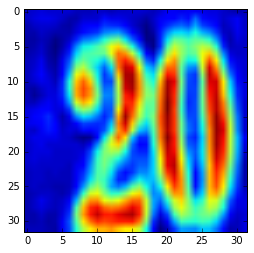

In [61]:
plt.imshow(X_train_sample[1])

In [60]:
y_train_sample[1]

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

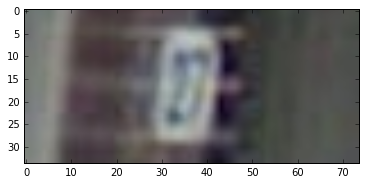

In [59]:
train_img_loc = train_loc_root + str(train_image_idxs[0]+1) + '.png'
train_img = img.imread(train_img_loc)
plt.imshow(train_img)

Repeat for the test data too.

In [96]:
ds_test_fname = os.path.join(test_loc_root, "digitStruct.mat")
test_digitstruct = DigitStructFile(ds_test_fname)
test_len = len(test_digitstruct.digitStructName)
test_image_idxs = rnd.sample(range(test_len), 4)
print "Indices: " + str(test_image_idxs)

X_test_sample = np.zeros((n_samples, 32, 32))
y_test_sample = np.zeros((n_samples, 6, 11))
label_enc = skproc.OneHotEncoder(n_values=11,sparse=False)
idx = 0

for i in test_image_idxs:
    
    test_dict = test_digitstruct.getDigitStructure(i)
    street_num_len = len(np.array(test_dict['label']))
    if street_num_len <= 5 and street_num_len > 0:
        curr_y = extract_label(test_dict, label_enc, 5)
        curr_X = extract_and_crop(test_loc_root, test_dict, 32)
        y_test_sample[idx,:,:] = curr_y
        X_test_sample[idx,:,:] = curr_X
        idx = idx + 1

Indices: [6892, 5093, 3792, 3716]


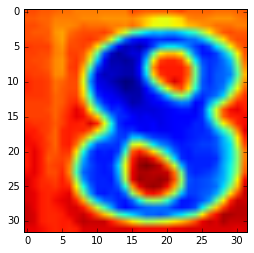

In [97]:
plt.imshow(X_test_sample[3])

In [98]:
y_test_sample[3]

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

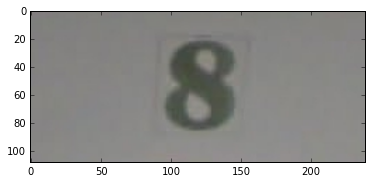

In [99]:
test_img_loc = test_loc_root + str(test_image_idxs[3]+1) + '.png'
test_img = img.imread(test_img_loc)
plt.imshow(test_img)

The following code tests my extraction and cropping routines for the **entire** dataset.

Invalid number! Index = 29929
(33401, 32, 32)
(33401, 6, 11)


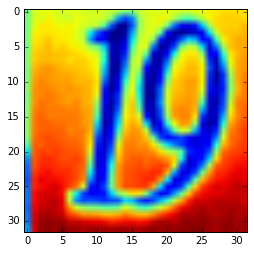

In [17]:
# Load and process the training data!
train_dataset = generate_svhn_dataset(train_loc_root, 11, 6, 32, 5)
print np.shape(train_dataset['data'])
print np.shape(train_dataset['labels'])
plt.imshow(train_dataset['data'][0])

In [18]:
# Send this data set to pkl
pickle_svhn("train", train_dataset)

(13068, 32, 32)
(13068, 6, 11)


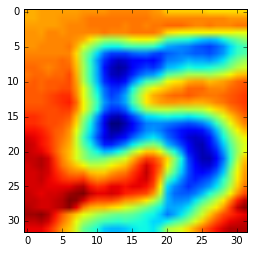

In [19]:
# Now the test data!
test_dataset = generate_svhn_dataset(test_loc_root, 11, 6, 32, 5)
print np.shape(test_dataset['data'])
print np.shape(test_dataset['labels'])
plt.imshow(test_dataset['data'][0])

In [20]:
pickle_svhn("test", test_dataset)